# Delayed Correlation: Vaccination and SARS-CoV-2 in Argentina

# PART 1: Delayed Correlation Analysis

# 1. Data Loading and Preparation
## 1.1 Library Import and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from tbats import TBATS
from sklearn.metrics import mean_squared_error
import seaborn as sb
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import spearmanr
from scipy import stats
from datetime import timedelta


In [2]:
os.chdir("C:\\Users\\Julian\\Desktop\\DATA\\Proyectos DS\\COVID19")

df_casos = pd.read_csv("owid-covid-data.csv",parse_dates=[3])

df_casos.columns


Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

Among all the columns, it is used 3:

 -*new_vaccinations_smoothed_per_million:* New vaccinations smoothed over one week per million people.
 
 -*people_fully_vaccinated_per_hundred:* People fully vaccinated per hundred inhabitants.
 
 -*new_cases_per_million:* New cases per million inhabitants.

In [3]:
#Filter for Argentina

condicion = df_casos['iso_code'] == "ARG"

# Apply the filtering condition to the DataFrame.
df_ARG_vacunas = df_casos[condicion]

# Temporal serie
tasadevacunacion_ARG = pd.Series(data=df_ARG_vacunas['new_vaccinations_smoothed_per_million'].values, index=pd.to_datetime(df_ARG_vacunas['date'].values))
proporcioninmuni_ARG = pd.Series(data=df_ARG_vacunas['people_fully_vaccinated_per_hundred'].values, index=pd.to_datetime(df_ARG_vacunas['date'].values))
casos_nuevos_suavi_ARG = pd.Series(data=df_ARG_vacunas['new_cases_per_million'].values, index=pd.to_datetime(df_ARG_vacunas['date'].values))


In [4]:
############################ WEEKLY DATA AND CASES ##################################
#####################################################################################
# Concatenate the series

combined_series_semanal = pd.concat([tasadevacunacion_ARG,proporcioninmuni_ARG], axis=1)
combined_series_semanal.columns = ['vacunados_pm_suavi','prop_inmuni']

#### FILTER THE SERIES UNTIL 2023-09-06 --> NaNs begin in cases #####
# Combined series
combined_series_semanal = combined_series_semanal[combined_series_semanal.index < '2023-09-06']

casos_nuevos_suavi_ARG = casos_nuevos_suavi_ARG[casos_nuevos_suavi_ARG.index < '2023-09-06']
df_semanal_casos = casos_nuevos_suavi_ARG.resample('7D').mean()


# Calculate the weekly mean of vaccinated and immunized individuals
combined_series_semanal = combined_series_semanal.resample('7D').mean()

# Concatenate the series
combined_series1 = pd.concat([combined_series_semanal,df_semanal_casos], axis=1)
combined_series_semanal_nolog= combined_series1.iloc[:, :3]
combined_series_semanal_nolog.columns = ['vacunados_pm_suavi','prop_inmuni', 'casos']


# Remove null values
combined_series_nonull_nolog= combined_series_semanal_nolog.dropna()

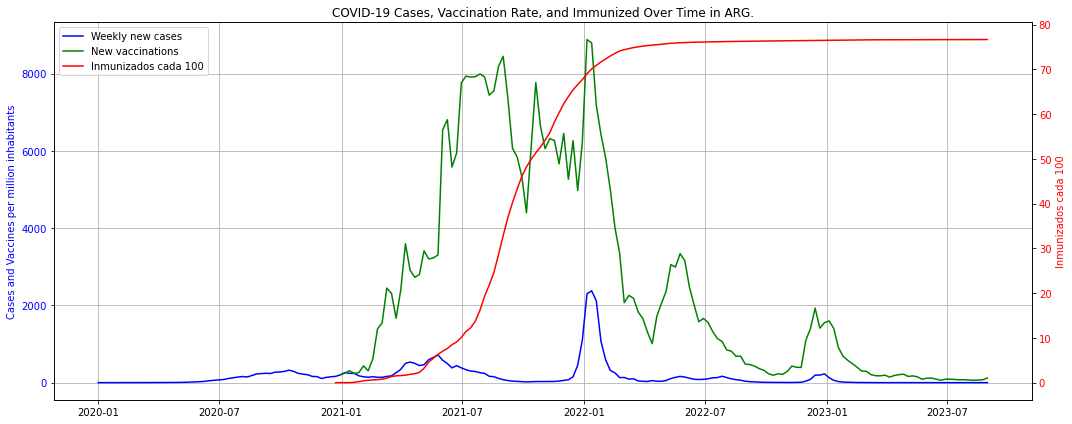

In [5]:
################################## THREE-VARIABLE CHART ###############################################
#######################################################################################################

# Set the chart dimensions
plt.figure(figsize=(15, 6))

# Configure the first Y-axis for COVID cases and vaccination rate
ax1 = sns.lineplot(x=combined_series_semanal_nolog.index, y="casos", data=combined_series_semanal_nolog, color='b', label='Weekly new cases')
sns.lineplot(x=combined_series_semanal_nolog.index, y="vacunados_pm_suavi", data=combined_series_semanal_nolog, color='g', label='New vaccinations', ax=ax1)
ax1.set_ylabel("Cases and Vaccines per million inhabitants", color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Establish a second Y-axis for the immunization rate.
ax2 = ax1.twinx()
sns.lineplot(x=combined_series_semanal_nolog.index, y="prop_inmuni", data=combined_series_semanal_nolog, color='r', label='Inmunizados cada 100', ax=ax2)
ax2.set_ylabel("Inmunizados cada 100", color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Configure the title and the legends.
plt.title("COVID-19 Cases, Vaccination Rate, and Immunized Over Time in ARG.")
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
# Remove the second legend in the upper right corner.
ax1.get_legend().remove()

# Remove the grid background.
ax1.grid(True)
ax2.grid(False)

# Rotate the labels on the X-axis for improved readability if necessary.
plt.xticks(rotation=45)

# Plot
plt.tight_layout()
plt.show()

At the end of December 2020, the vaccination campaign began in Argentina.

## 1.2 Data Transformation:

        Daily --> Weekly
        Cases --> log10(cases +1)
        Filtered the series until 2023-09-06


In [6]:
############################ Weekly Data and Logarithmic Cases #########################
########################################################################################
#Concatenate the series.

combined_series_semanal = pd.concat([tasadevacunacion_ARG,proporcioninmuni_ARG], axis=1)
combined_series_semanal.columns = ['vacunados_pm_suavi','prop_inmuni']

#### Filter the series until 2023-09-06 --> NaN cases start. #####
#The combined series
combined_series_semanal = combined_series_semanal[combined_series_semanal.index < '2023-09-06']
#The cases series
casos_nuevos_suavi_ARG = casos_nuevos_suavi_ARG[casos_nuevos_suavi_ARG.index < '2023-09-06']
#Calculate the weekly mean of cases and apply a base-10 logarithm.
df_semanal_casos = casos_nuevos_suavi_ARG.resample('7D').mean()
df_semanal_casos = np.log10(df_semanal_casos + 1)

#Calculate the weekly mean of vaccinated and immunized individuals.
combined_series_semanal = combined_series_semanal.resample('7D').mean()

#Concatenate the series
combined_series = pd.concat([combined_series_semanal,df_semanal_casos], axis=1)
combined_series_semanal= combined_series.iloc[:, :3]
combined_series_semanal.columns = ['vacunados_pm_suavi','prop_inmuni', 'log_casos']


#Eliminate null values
combined_series_nonull= combined_series.dropna()

## 1.3 Functions to obtain correlations with a specific lag

In [7]:
#Function to calculate correlation coefficient
#Using Pearson and Spearman methods

#Pearson 

def corr_ret_Pearson(vaccination_rate, cases, delay):
    delayed_cases = cases[delay:]
    if len(vaccination_rate) > len(delayed_cases):
        truncated_vaccination_rate = vaccination_rate[:len(delayed_cases)]
        coef_corr = np.corrcoef(delayed_cases, truncated_vaccination_rate)[0, 1]
        return(coef_corr)
    elif len(vaccination_rate) < len(delayed_cases):
        truncated_delayed_cases = delayed_cases[:len(vaccination_rate)]
        coef_corr = np.corrcoef(truncated_delayed_cases, vaccination_rate)[0, 1]
        return(coef_corr)
    else:
        coef_corr = np.corrcoef(delayed_cases, vaccination_rate)[0, 1]
        return(coef_corr)

#Spearman

def corr_ret_Spearman(vaccination_rate, cases, delay):
    delayed_cases = cases[delay:]
    if len(vaccination_rate) > len(delayed_cases):
        truncated_vaccination_rate = vaccination_rate[:len(delayed_cases)]
        coef_corr, _ = spearmanr(delayed_cases, truncated_vaccination_rate)
        return coef_corr
    elif len(vaccination_rate) < len(delayed_cases):
        truncated_delayed_cases = delayed_cases[:len(vaccination_rate)]
        coef_corr, _ = spearmanr(truncated_delayed_cases, vaccination_rate)
        return coef_corr
    else:
        coef_corr, _ = spearmanr(delayed_cases, vaccination_rate)
        return coef_corr



# 2. Delayed correlation analysis among the different variables
## Correlation between weekly vaccination rate and weekly cases.

In [8]:
#Replace null with 0
combined_series_semanal.fillna(0, inplace=True)

# Extract values of 'cases' and 'vaccination' columns into lists
casos_nuevos_suavi_values = combined_series_semanal['log_casos'].tolist()
tasa_vacunacion_values = combined_series_semanal['vacunados_pm_suavi'].tolist()

# Print the first few values as a sample
print("Cases:", casos_nuevos_suavi_values[:5])
print("Vaccination:", tasa_vacunacion_values[:5])

# Find the index where one of the lists starts to have values greater than 0.
index_to_start = next((i for i, (x, y) in enumerate(zip(casos_nuevos_suavi_values, tasa_vacunacion_values)) if x > 0 or y > 0), len(casos_nuevos_suavi_values))

# Remove the initial elements (0) up to the found index.
casos_nuevos_suavi_values_ok = casos_nuevos_suavi_values[index_to_start:]
tasa_vacunacion_values_ok = tasa_vacunacion_values[index_to_start:]

Cases: [0.0, 0.0, 0.0, 0.0, 0.0]
Vaccination: [0.0, 0.0, 0.0, 0.0, 0.0]


### 2.1.1 Scatterplot of new cases and vaccination rate WITHOUT DELAY

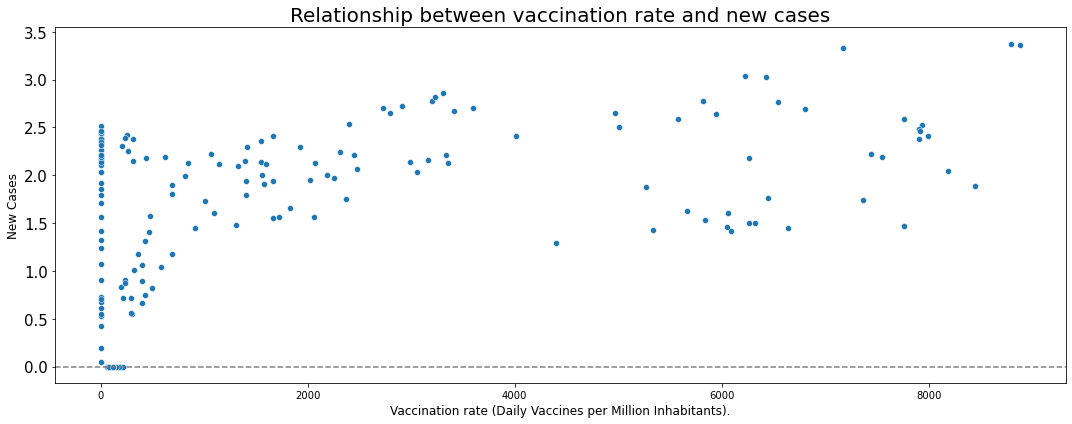

In [9]:
plt.figure(figsize=(15, 6))
sns.scatterplot(x=tasa_vacunacion_values_ok, y=casos_nuevos_suavi_values_ok)
plt.xlabel('Vaccination rate (Daily Vaccines per Million Inhabitants).', fontsize=12)
plt.ylabel('New Cases', fontsize=12)
plt.title('Relationship between vaccination rate and new cases', fontsize=20)
plt.yticks(fontsize=15)
plt.axhline(0, color='gray', linestyle='--')

plt.tight_layout()


plt.show()

It can be observed that, despite a prolonged period during which the vaccination rate remained at zero, the levels of case incidence in that interval did not significantly increase.

This is because during the 2020 period before vaccination, there were public policies of mandatory preventive social isolation that mitigated the spread of COVID-19.

On March 19, 2020, a nationwide quarantine was established. Subsequently, the government gradually eased the quarantine to varying degrees until the arrival of vaccines in December.


### 2.1.2 Analysis of Delays

In [10]:
#List of Delays to Evaluate
delay_weeks_values = [4,8,12,16,20,24,28,32,36,40,44,48,52,56,60]
#Lists to Save the Results
resultados_corr_Speraman = []
resultados_corr_Pearson = []

for delay in delay_weeks_values:
    print(f"Correlation with a {delay}-week delay:")
    corr = corr_ret_Spearman(tasa_vacunacion_values_ok, casos_nuevos_suavi_values, delay)
    print(corr)
    resultados_corr_Speraman.append(corr)
    
for delay in delay_weeks_values:
    print(f"Correlation with a {delay}-week delay:")
    corr = corr_ret_Pearson(tasa_vacunacion_values_ok, casos_nuevos_suavi_values, delay)
    print(corr)
    resultados_corr_Pearson.append(corr)

Correlation with a 4-week delay:
0.43617207803360447
Correlation with a 8-week delay:
0.41166073238535333
Correlation with a 12-week delay:
0.2971847837020367
Correlation with a 16-week delay:
0.1329071675865278
Correlation with a 20-week delay:
-0.008368398562064306
Correlation with a 24-week delay:
-0.12552572221965222
Correlation with a 28-week delay:
-0.1828088431514303
Correlation with a 32-week delay:
-0.20961230928620456
Correlation with a 36-week delay:
-0.21056695103401776
Correlation with a 40-week delay:
-0.22334554566798898
Correlation with a 44-week delay:
-0.2795395090129244
Correlation with a 48-week delay:
-0.28579348097825863
Correlation with a 52-week delay:
-0.28880051828867664
Correlation with a 56-week delay:
-0.27621536604990604
Correlation with a 60-week delay:
-0.3168721433251049
Correlation with a 4-week delay:
0.43899280259536727
Correlation with a 8-week delay:
0.4782800913774949
Correlation with a 12-week delay:
0.4069588378955256
Correlation with a 16-week 

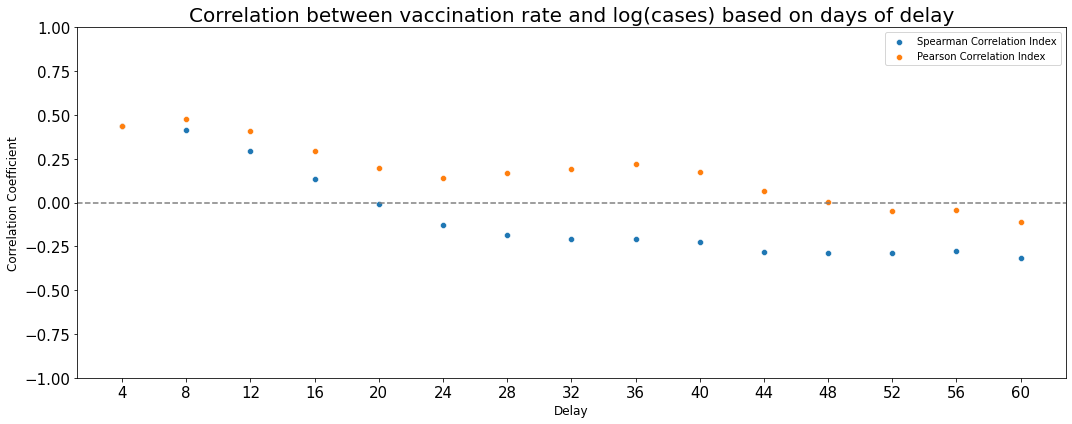

In [11]:
    #################### SCATTERPLOT ####################
    #####################################################
plt.figure(figsize=(15, 6))
sns.scatterplot(x=delay_weeks_values, y=resultados_corr_Speraman, label='Spearman Correlation Index')
sns.scatterplot(x=delay_weeks_values, y=resultados_corr_Pearson, label='Pearson Correlation Index')
plt.xlabel('Delay', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.title('Correlation between vaccination rate and log(cases) based on days of delay', fontsize=20)
plt.xticks(range(min(delay_weeks_values), max(delay_weeks_values) + 1,4), fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(-1, 1)

# Add a line in Y=0
plt.axhline(0, color='gray', linestyle='--')

plt.tight_layout()
plt.show()

### 2.1.3 Analysis with a 52-week delay

In [12]:
#Obtain the values of new cases with a 52-week delay
start_index = 51
casos_nuevos_suavi_values_ok = casos_nuevos_suavi_values[start_index:]

#Obtain the values of vaccination rate
end_index = 193 - 52
tasa_vacunacion_values_ok = tasa_vacunacion_values_ok[:end_index]

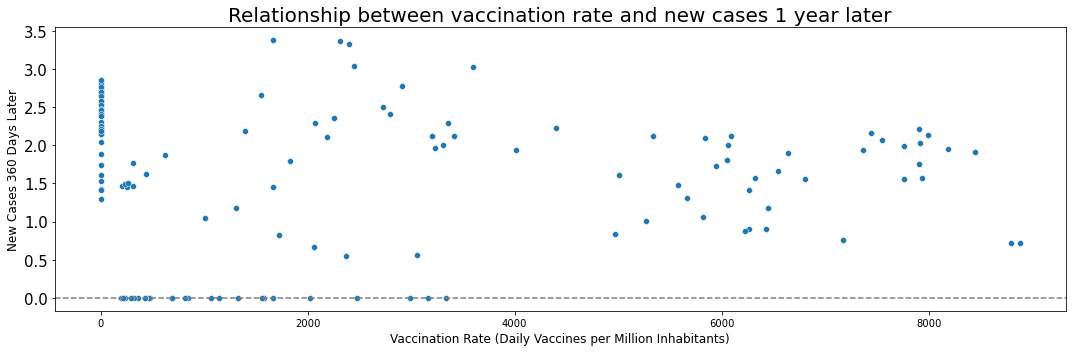

In [13]:
plt.figure(figsize=(15, 5))
sns.scatterplot(x=tasa_vacunacion_values_ok, y=casos_nuevos_suavi_values_ok)
plt.xlabel('Vaccination Rate (Daily Vaccines per Million Inhabitants)', fontsize=12)
plt.ylabel('New Cases 360 Days Later', fontsize=12)
plt.title('Relationship between vaccination rate and new cases 1 year later', fontsize=20)
plt.yticks(fontsize=15)

# Add a line at the value 0 on the Y-axis
plt.axhline(0, color='gray', linestyle='--')

plt.tight_layout()
plt.show()

Both the low correlation and the graphical representation indicate a weak relationship between the two variables.

The delayed vaccination rate does not appear to be very explanatory of what will happen with the case rate in the future.

## 2.2 Correlation between fully immunized individuals and weekly cases

In [15]:
#Fill nulls with 0
combined_series_semanal.fillna(0, inplace=True)

# Extract values from the 'cases' and 'vaccination' columns into lists.
casos_nuevos_suavi_values = combined_series_semanal['log_casos'].tolist()
prop_inmuni_values = combined_series_semanal['prop_inmuni'].tolist()

# Print the first few values as a sample
print("Cases:", casos_nuevos_suavi_values[:5])
print("Prop inmuni:", prop_inmuni_values[:5])

# Find the index where one of the lists starts to have values greater than 0
index_to_start = next((i for i, (x, y) in enumerate(zip(casos_nuevos_suavi_values, prop_inmuni_values)) if x > 0 or y > 0), len(casos_nuevos_suavi_values))

# Remove the initial elements (0) up to the found index
casos_nuevos_suavi_values_ok = casos_nuevos_suavi_values[index_to_start:]
prop_inmuni_values_ok = prop_inmuni_values[index_to_start:]

Cases: [0.0, 0.0, 0.0, 0.0, 0.0]
Prop inmuni: [0.0, 0.0, 0.0, 0.0, 0.0]


### 2.2.1 Scatterplot between weekly new cases and proportion of immunized *without delay*

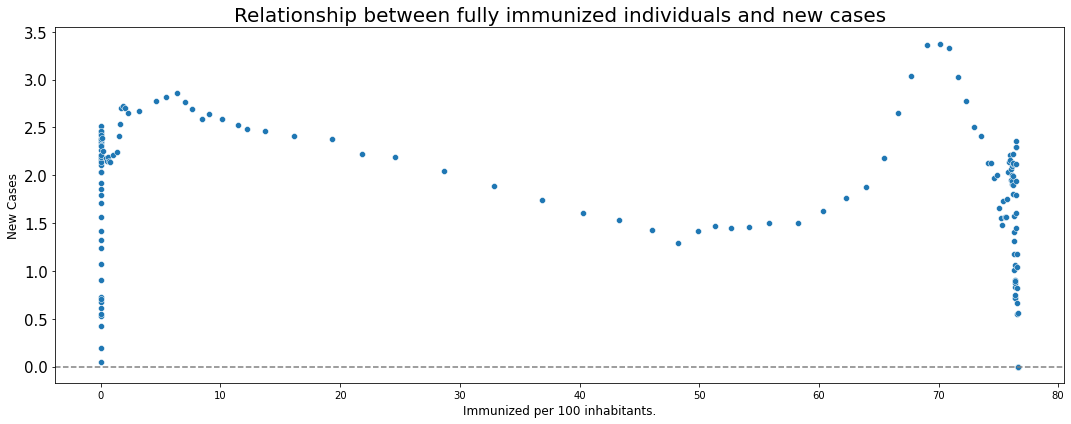

In [16]:
plt.figure(figsize=(15, 6))
sns.scatterplot(x=prop_inmuni_values_ok, y=casos_nuevos_suavi_values_ok)
plt.xlabel('Immunized per 100 inhabitants.', fontsize=12)
plt.ylabel('New Cases', fontsize=12)
plt.title('Relationship between fully immunized individuals and new cases', fontsize=20)
plt.yticks(fontsize=15)


# Add a line at the value 0 on the Y-axis
plt.axhline(0, color='gray', linestyle='--')

plt.tight_layout()
plt.show()

In [18]:
delay_weeks_values = [4,8,12,16,20,24,28,32,36,40,44,48,52,56,60]
resultados_corr_Pearson = []
resultados_corr_Spearman = []
for delay in delay_weeks_values:
    print(f"Correlation with a {delay}-week delay.")
    corr = corr_ret_Pearson(prop_inmuni_values_ok, casos_nuevos_suavi_values, delay)
    print(corr)
    resultados_corr_Pearson.append(corr)
    
for dias_retraso in delay_weeks_values:
    print(f"Correlation with a {delay}-week delay.")
    corr = corr_ret_Spearman(prop_inmuni_values_ok, casos_nuevos_suavi_values, delay)
    print(corr)
    resultados_corr_Spearman.append(corr)

Correlation with a 4-week delay.
-0.26911592989891003
Correlation with a 8-week delay.
-0.38204842169187725
Correlation with a 12-week delay.
-0.4694267690191338
Correlation with a 16-week delay.
-0.5335957981265879
Correlation with a 20-week delay.
-0.5880801146835106
Correlation with a 24-week delay.
-0.6257937290122181
Correlation with a 28-week delay.
-0.6600680062385392
Correlation with a 32-week delay.
-0.6917787894269805
Correlation with a 36-week delay.
-0.7165995556291026
Correlation with a 40-week delay.
-0.732802832099198
Correlation with a 44-week delay.
-0.7476921055611503
Correlation with a 48-week delay.
-0.7666356140618196
Correlation with a 52-week delay.
-0.7856021470994353
Correlation with a 56-week delay.
-0.8009530084455427
Correlation with a 60-week delay.
-0.8169472326724528
Correlation with a 60-week delay.
-0.7570242523845784
Correlation with a 60-week delay.
-0.7570242523845784
Correlation with a 60-week delay.
-0.7570242523845784
Correlation with a 60-week de

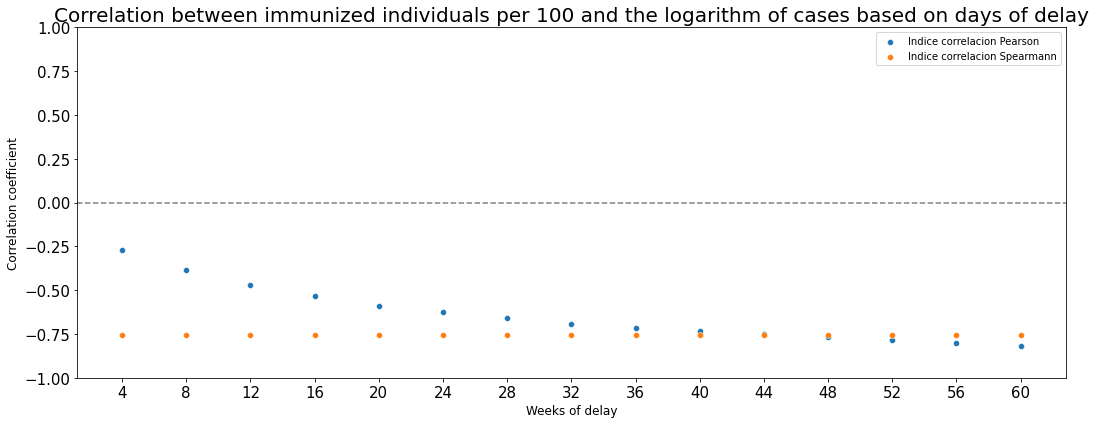

In [19]:
plt.figure(figsize=(15, 6))
sns.scatterplot(x=delay_weeks_values, y=resultados_corr_Pearson, label='Indice correlacion Pearson')
sns.scatterplot(x=delay_weeks_values, y=resultados_corr_Spearman, label='Indice correlacion Spearmann')
plt.xlabel('Weeks of delay', fontsize=12)
plt.ylabel('Correlation coefficient', fontsize=12)
plt.title('Correlation between immunized individuals per 100 and the logarithm of cases based on days of delay', fontsize=20)
plt.xticks(range(min(delay_weeks_values), max(delay_weeks_values) + 1,4), fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(-1, 1)

# add a line at the Y-axis value of 0
plt.axhline(0, color='gray', linestyle='--')

plt.tight_layout()
plt.show()

Values obtained are significantly higher in absolute terms than those observed with the vaccination rate.

It will be used a 52-day lag, approximately one year.

## 2.2. The relationship between the proportion of immunized individuals and new cases with a 52-week delay.

In [20]:
# Obtain the values of new cases with a 52-week delay
start_index = 51
casos_nuevos_suavi_values_ok = casos_nuevos_suavi_values[start_index:]

# Obtain the values of inmunizations with a 52-week delay
end_index = 193 - 52
prop_inmuni_values_ok = prop_inmuni_values_ok[:end_index]

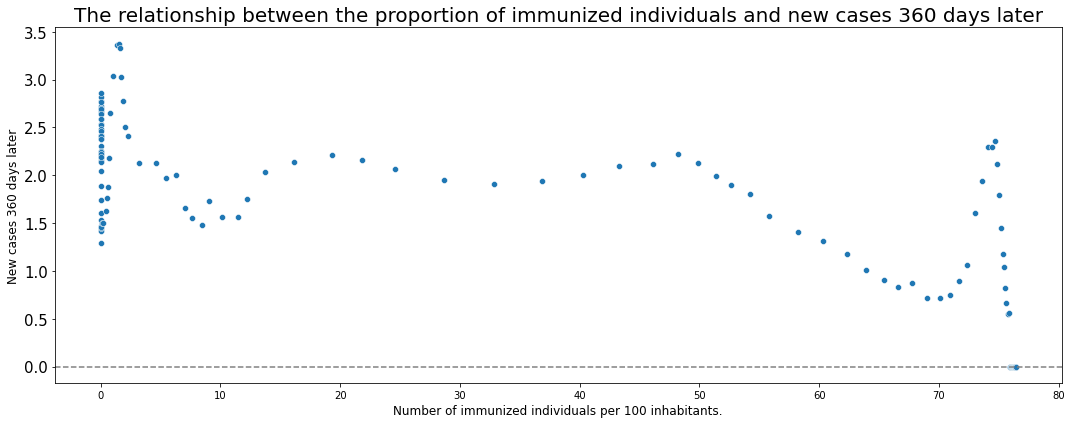

In [21]:
plt.figure(figsize=(15, 6))
sns.scatterplot(x=prop_inmuni_values_ok, y=casos_nuevos_suavi_values_ok)
plt.xlabel('Number of immunized individuals per 100 inhabitants.', fontsize=12)
plt.ylabel('New cases 360 days later', fontsize=12)
plt.title('The relationship between the proportion of immunized individuals and new cases 360 days later', fontsize=20)

plt.yticks(fontsize=15)

plt.axhline(0, color='gray', linestyle='--')

plt.tight_layout()
plt.show()

There is a much stronger correlation between the number of immunized individuals per 100 people and new cases 52 weeks (one year) later.






# 3. Multiple linear regression analysis

In order to observe how the dependent variable (cases) is related to the two independent variables (vaccination rate and number of immunized individuals).

In [22]:
##### Data preparation ####
df_retrasos = pd.DataFrame({'Casos_retraso': casos_nuevos_suavi_values_ok, 'Inmunizados':prop_inmuni_values_ok,'Tasa de vacunacion':tasa_vacunacion_values_ok})

In [23]:
import plotly.express as px
import numpy as np
import statsmodels.formula.api as smf

x1 = df_retrasos["Tasa de vacunacion"]
x2 = df_retrasos["Inmunizados"]
y = df_retrasos["Casos_retraso"]

# Adjust the model
mod = smf.ols('y ~ x1 + x2 ', data=df_retrasos).fit()

# Generate a grid of points in the x1-x2 space
x1_range = np.linspace(min(x1), max(x1), num=20)
x2_range = np.linspace(min(x2), max(x2), num=20)
x1_mesh, x2_mesh = np.meshgrid(x1_range, x2_range)

# Calculate the model predictions on the grid
data_pred = {'x1': x1_mesh.ravel(), 'x2': x2_mesh.ravel()}
y_pred = mod.predict(exog=data_pred).values
y_pred = y_pred.reshape(x1_mesh.shape)

# Create the interactive chart
fig = px.scatter_3d(df_retrasos, x='Tasa de vacunacion', y='Inmunizados', z='Casos_retraso',
                    title='relationship between Vaccination Rate, Immunized Individuals, and Cases')

# Add the fitted plane to the chart
fig.add_surface(x=x1_range, y=x2_range, z=y_pred, colorscale='Viridis', opacity=0.7)

fig.show()


In [24]:
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     122.4
Date:                Thu, 28 Sep 2023   Prob (F-statistic):           2.66e-31
Time:                        15:52:16   Log-Likelihood:                -121.28
No. Observations:                 141   AIC:                             248.6
Df Residuals:                     138   BIC:                             257.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2089      0.074     29.719      0.0

# 4. Simple linear regression (Immunized:Cases).

In order to avoid multicollinearity, a single variable regression will be modeled.

c:\Users\Julian\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



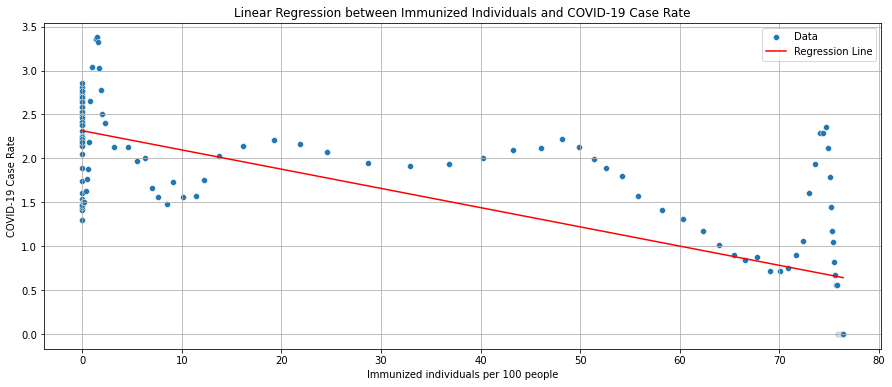

Slope (Regression Coefficient): -0.02189746953129783
intercept: 2.3146614229312847
R2: 0.6103748575561947
p-value: 3.054029423507454e-30


In [25]:
tasa_casos_covid = casos_nuevos_suavi_values_ok 
inmunizados = prop_inmuni_values_ok  

# Linear Regression
slope, intercept, r_value, p_value, std_err = stats.linregress(inmunizados, tasa_casos_covid)

# Create an array of values for the regression line
x = np.array(inmunizados)
y = slope * x + intercept

# Plot the data and the regression line
plt.figure(figsize=(15, 6))
sns.scatterplot(inmunizados, tasa_casos_covid, label='Data')
plt.plot(x, y, color='red', label='Regression Line')
plt.xlabel('Immunized individuals per 100 people')
plt.ylabel('COVID-19 Case Rate')
plt.title('Linear Regression between Immunized Individuals and COVID-19 Case Rate')
plt.legend()
plt.grid(True)

#plt.savefig('corr_inmuni.png')


plt.show()

# Print regression results
print(f"Slope (Regression Coefficient): {slope}")
print(f"intercept: {intercept}")
print(f"R2: {r_value**2}")
print(f"p-value: {p_value}")


Slope (Regression Coefficient): According to the model, an increase of 1 unit in the predictor variable is associated with a decrease of approximately 0.0219 units in the dependent variable (response).

Coefficient of Correlation (R-squared): Approximately 61.04% of the variability in the dependent variable is explained by the predictor variable in the model. This indicates a moderate relationship between the two variables.

p-value: The p-value associated with the model is very low (3.05e-30), suggesting that the model as a whole is statistically significant. In other words, the relationship between the variables is highly unlikely to occur by chance.

# Part I: CONCLUSION

## Vaccination rate and rate of cases:
In relation to the vaccination rate and the rate of cases with a one-year lag, no statistically significant negative correlation was observed. This lack of correlation may be attributed to the inherent variability in the vaccination rate.

Furthermore, it should be noted that the vaccination rate does not account for the overall coverage of immunized individuals within the population. While a high vaccination rate is generally associated with a decrease in cases, this correlation may vary depending on the percentage of immunized individuals.

Therefore, the correlation may become more evident when considering the quantity of individuals who have surpassed the individual immunization period.

## Individuals fully immunized per 100 people:

With the variable 'individuals fully immunized per 100 people,' a much stronger relationship was identified. This is likely due to the fact that this variable takes into account vaccination coverage at the population level.

Despite the presence of other factors that could potentially influence the COVID-19 case rate in Argentina, such as public health interventions and virus mutations, the robustness of the observed relationship between these two variables makes it highly improbable that this correlation is purely random.

## Regression model

The regression model proved effective in modeling the relationship between the COVID-19 case rate and the proportion of immunized individuals in Argentina. However, it is crucial to note that in a regression model, independent variables are treated as constants and are used to predict the dependent variable based on their known values at the time of measurement. As a result, the model's ability to make accurate predictions about the future COVID-19 case rate is limited, as it does not account for temporal changes or the time dynamics of the pandemic.

Hence, SARIMAX models are more suitable as a forecasting method because they have the capability to capture seasonal patterns and trends in the original data.


###
###
###
### END OF PART I
###
###
###

# Part 2: Exploratory Analysis of the Time Series - SARIMAX Model

In this section, it will be conducted an exploratory analysis of the time series data using the Seasonal Autoregressive Integrated Moving Average (SARIMAX) model.

# 1. Data Selection and Data Preparation for SARIMAX Modeling

## 1.1 Data Selection

In [26]:
## Data
df_casos = combined_series_nonull[0]

# 2. Analysis of Stationarity

Stationarity is a critical assumption for many time series models, including the Seasonal Autoregressive Integrated Moving Average with Exogenous Factors (SARIMAX) model. A stationary time series is one whose statistical properties, such as mean, variance, and autocorrelation, do not change over time. 

## 2.1 Analysis of Stationarity Without Differencing

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


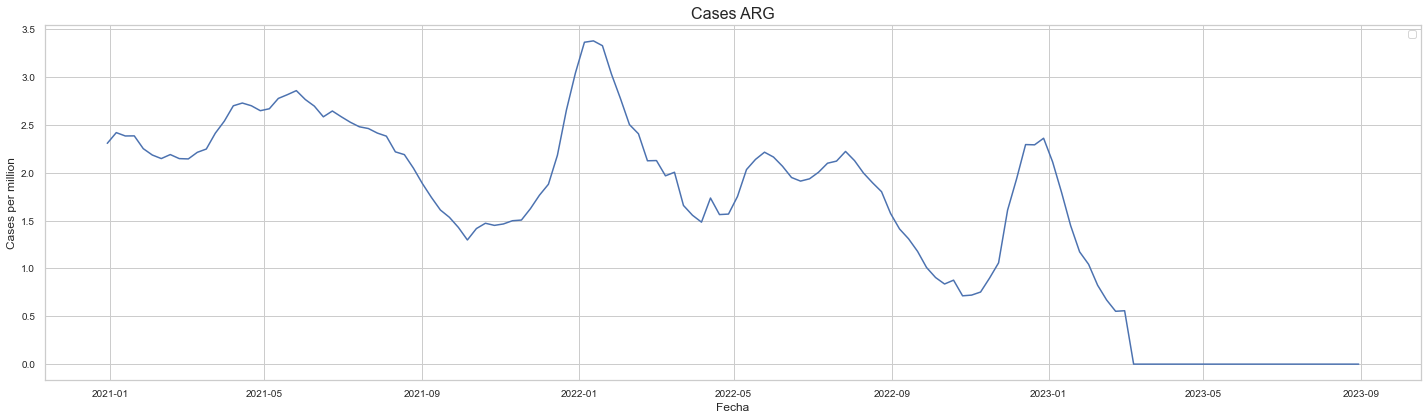

In [27]:
#Plotting the Serie
sns.set(style="whitegrid")  

plt.figure(figsize=(20, 6))
sns.lineplot(data=df_casos)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Cases per million', fontsize=12)
plt.title('Cases ARG', fontsize=16)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

##### For time series analyses, we have excluded values prior to 2020-12-01:

        COVID-19 transmission patterns underwent significant changes from that point onward, attributed to shifts in public policy, such as the varying degrees of relaxation of social distancing measures and the commencement of the vaccination campaign in Argentina.

        The utilization of data preceding December 2020 could introduce noise into the analysis.

## 2.1.1 Autocorrelation Functions (ACF)



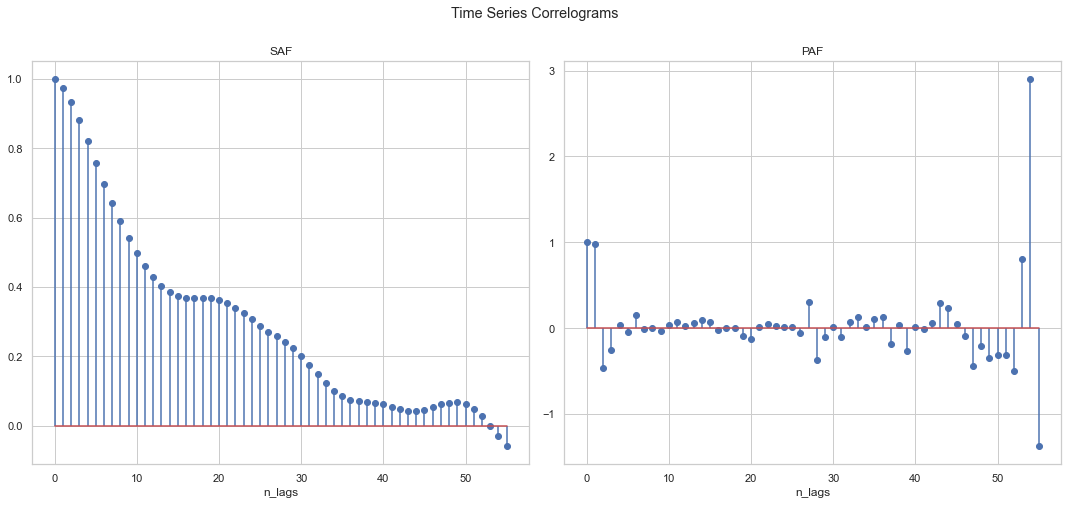

In [28]:
#SAF
fas = sm.tsa.acf(df_casos, nlags=55)

#PAF
fap = sm.tsa.pacf(df_casos, nlags=55) #Puede dar valores >1 cuando la serie no es estacionaria

fig, axs = plt.subplots(1, 2, figsize=(15,7))
fig.suptitle('Time Series Correlograms', y=1)
axs[0].stem(fas)
axs[0].set_title('SAF')
axs[0].set_xlabel('n_lags')
axs[0].grid(True)
axs[1].stem(fap)
axs[1].set_title('PAF')
axs[1].set_xlabel('n_lags')
axs[1].grid(True)
plt.tight_layout()
plt.show()


The graph indicates a decrease in correlation as the lag between observations increases.

The high values at lags 50 and beyond in the PACF: They may indicate hints of a possible annual seasonality.

## 2.1.2 Moving Averages and Standard Deviation (STD) 

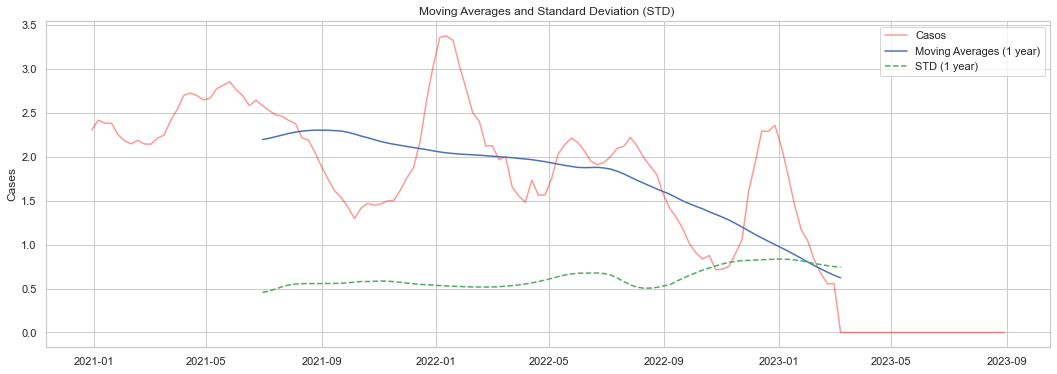

In [29]:
MMd = df_casos.rolling(52, center=True).mean()
STDd = df_casos.rolling(52, center=True).std()

plt.figure(figsize=(18,6))
plt.plot(df_casos, linestyle='-', color='red', alpha=0.4, label='Casos')
plt.plot(MMd, linestyle='-', color='b', label='Moving Averages (1 year)')
plt.plot(STDd, linestyle='--', color='g', label='STD (1 year)')
plt.ylabel('Cases')
plt.title('Moving Averages and Standard Deviation (STD) ', y=1)
plt.legend()
plt.show()

*Moving Average (1 year):* A decreasing trend over time is observed.

*Standard Deviation (1 year):* An increase in variance is observed.



## 2.1.3 Stationarity Test


*H₀ (Null Hypothesis) = The time series is not stationary.*

*H₁ (Alternative Hypothesis) = The time series is stationary.*


In [30]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=["Test Statistic", "p-value",
                                             "Lags Used", "Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    

adf_test(df_casos)
#Determine whether differencing is necessary or not
print('\nDifferences required according to ADF:', pm.arima.utils.ndiffs(df_casos, test='adf'))
print('\n')


Results of Dickey-Fuller Test:
Test Statistic                  -1.040396
p-value                          0.738247
Lags Used                        5.000000
Number of Observations Used    134.000000
Critical Value (1%)             -3.480119
Critical Value (5%)             -2.883362
Critical Value (10%)            -2.578407
dtype: float64

Differences required according to ADF: 1




*p > 0.05*: There is no evidence to reject the null hypothesis --> The series is NOT stationary.


## 2.1.4 Time Series Decomposition

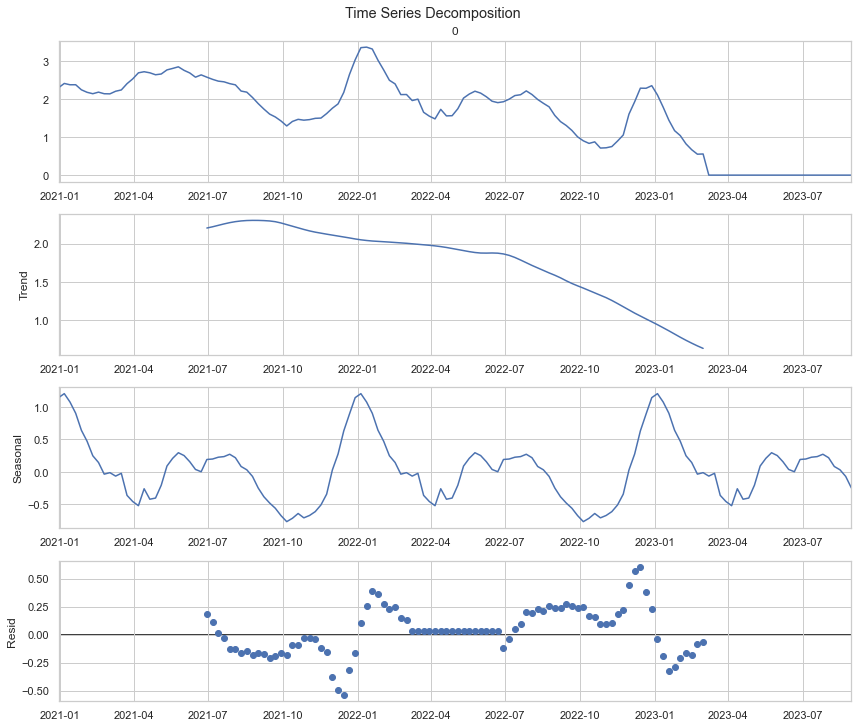

In [31]:
descomposicion_d = seasonal_decompose(df_casos, model='aditive') 

plt.rcParams.update({'figure.figsize': (12,10)})
descomposicion_d.plot().suptitle('Time Series Decomposition', y=1.01)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


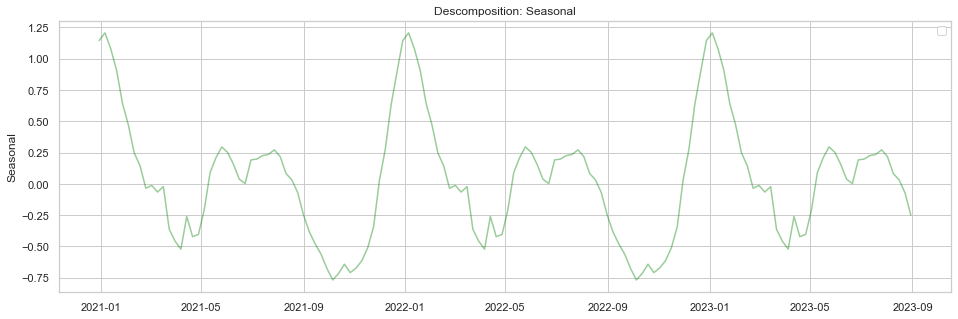

In [32]:
S = descomposicion_d.seasonal

plt.figure(figsize=(16,5))
plt.plot(S, linestyle='-', color='green', alpha=0.4)
plt.ylabel('Seasonal')
plt.title('Descomposition: Seasonal', y=1)
plt.legend()
plt.show()

#### Indicates a well-defined annual seasonality with:
        -An increase in cases during the summer.
        -A pronounced decrease until April.
        -An increase in cases during the winter, forming a sort of plateau until spring.
        -A pronounced decrease until October.


## 2.2 Analysis of Stationarity - With Differencing

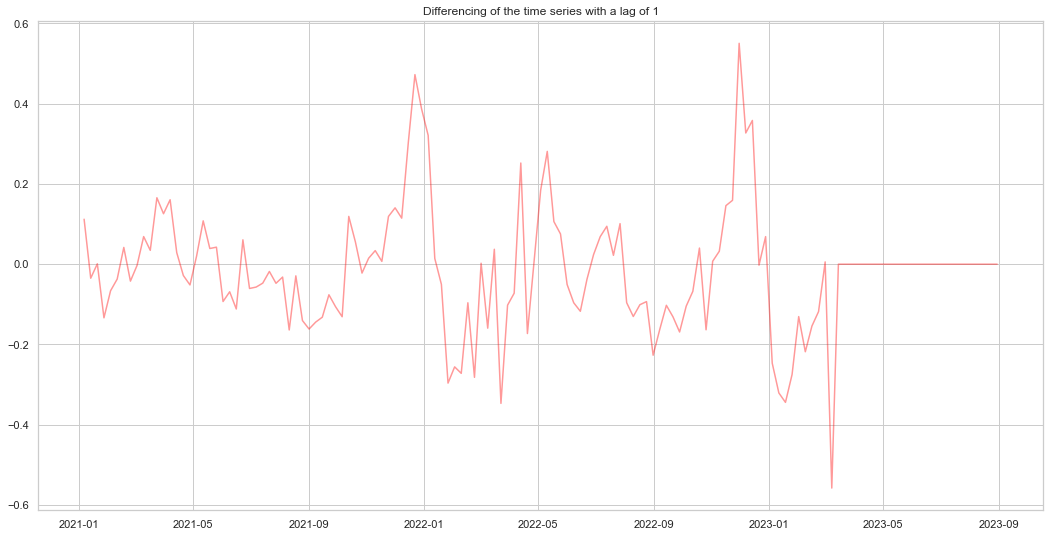

In [33]:
dif = sm.tsa.statespace.tools.diff(df_casos, k_diff=1)

plt.figure(figsize=(18,9))
plt.plot(dif, linestyle='-', color='red', alpha=0.4, label='data')
plt.title('Differencing of the time series with a lag of 1')

plt.show()
plt.show()


## 2.2.1 Autocorrelation Functions (ACF)

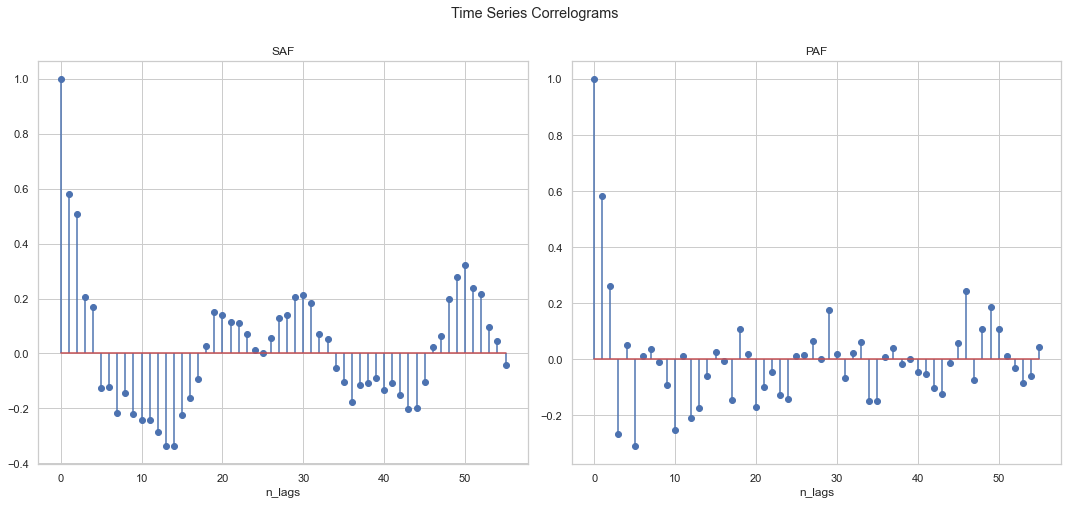

In [34]:
#SAF
fas = sm.tsa.acf(dif, nlags=55)

#PAF
fap = sm.tsa.pacf(dif, nlags=55) #Puede dar valores >1 cuando la serie no es estacionaria

fig, axs = plt.subplots(1, 2, figsize=(15,7))
fig.suptitle('Time Series Correlograms', y=1)
axs[0].stem(fas)
axs[0].set_title('SAF')
axs[0].set_xlabel('n_lags')
axs[0].grid(True)
axs[1].stem(fap)
axs[1].set_title('PAF')
axs[1].set_xlabel('n_lags')
axs[1].grid(True)
plt.tight_layout()
plt.show()

##### *lag 13*

        -The lag of 13 corresponds to 3 months, which could indicate a negative quarterly seasonality.

        -Every 3 months, the values increase or decrease based on the data point from 3 months earlier.

##### *lag 50*

        -The positive correlation in the values of lags near 50 could indicate a certain annual seasonality.

## 2.2.2 Moving Average and Standard Deviation (STD)

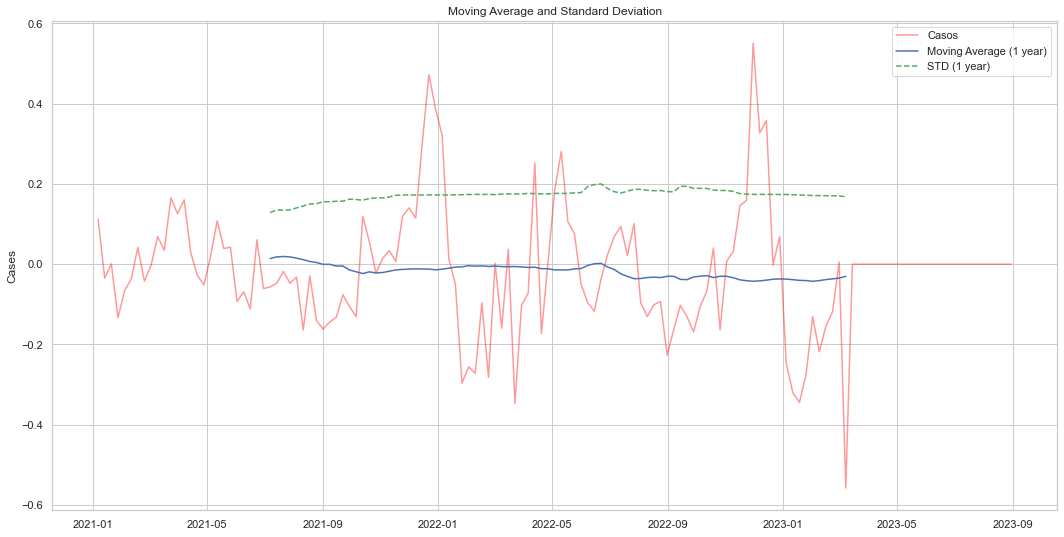

In [35]:
MMd = dif.rolling(52, center=True).mean()
STDd = dif.rolling(52, center=True).std()

plt.figure(figsize=(18,9))
plt.plot(dif, linestyle='-', color='red', alpha=0.4, label='Casos')
plt.plot(MMd, linestyle='-', color='b', label='Moving Average (1 year)')
plt.plot(STDd, linestyle='--', color='g', label='STD (1 year)')
plt.ylabel('Cases')
plt.title('Moving Average and Standard Deviation', y=1)
plt.legend()
plt.show()

It can be observed that both the variance and the mean exhibit greater stability, without displaying a specific trend.

## 2.2.3. Stationarity Test - With Differencing


*H₀ (Null Hypothesis) = The time series is not stationary.*

*H₁ (Alternative Hypothesis) = The time series is stationary.*


In [36]:
adf_test(dif)

print('\nDifferences required according to ADF:', pm.arima.utils.ndiffs(dif, test='adf'))
print('\n')

Results of Dickey-Fuller Test:


Test Statistic                  -5.453640
p-value                          0.000003
Lags Used                        4.000000
Number of Observations Used    134.000000
Critical Value (1%)             -3.480119
Critical Value (5%)             -2.883362
Critical Value (10%)            -2.578407
dtype: float64

Differences required according to ADF:: 0




*p << 0.01* : There is evidence to reject the null hypothesis --> The series can be considered stationary.

According to the tests and analyses, *it can be classified this series as stationary, even though it exhibits a seasonal pattern.*

# 3. SARIMAX Model
## 3.1. Hyperparameter Selection

In [37]:
# Train y test (80:20)
train = df_casos[:'2023-02-15']
test = df_casos['2023-02-15':'2023-08-30'] 


In [38]:
# Ranges of Potential Optimal Hyperparameter Values Candidates
p_values = [2,4]
d_values = [1]
q_values = [17, 18, 6, 4]
P_values = [1,2]
D_values = [0, 1]
Q_values = [0]
s_values = [52]  # Anual seasonality


best_mse = float('inf')
best_params = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        for s in s_values:
                            try:
                                # Build SARIMAX MODEL
                                modelo_sarima = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
                                resultados_sarima = modelo_sarima.fit()
                                predicciones = resultados_sarima.get_forecast(steps=len(train))
                                mse = mean_squared_error(train, predicciones.predicted_mean)
                                
                                if mse < best_mse:
                                    best_mse = mse
                                    best_params = (p, d, q, P, D, Q, s)
                                    
                                print(f'Order: ({p},{d},{q}) - Seasonal: ({P},{D},{Q},{s}) - MSE: {mse}')
                            except Exception as e:
                                print(f'Error in ({p},{d},{q}), ({P},{D},{Q},{s}): {e}')
                                continue

print(f"Best combination of hyperparameters: {best_params}")
print(f"MSE más bajo: {best_mse}")

KeyboardInterrupt: 

Best Hyperparameter Combination: (2, 1, 17, 1, 0, 0, 52)

Lowest MSE: 0.3976784241548036

In [39]:
modelo_sarima = SARIMAX(train, order=(2, 1, 17), seasonal_order=(1, 0, 0, 52))
resultados_sarima = modelo_sarima.fit()
print('Resumen modelo SARIMA\n', resultados_sarima.summary())

c:\Users\Julian\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Resumen modelo SARIMA
                                       SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  112
Model:             SARIMAX(2, 1, 17)x(1, 0, [], 52)   Log Likelihood                 101.113
Date:                              Thu, 28 Sep 2023   AIC                           -160.227
Time:                                      15:54:21   BIC                           -103.327
Sample:                                  12-30-2020   HQIC                          -137.144
                                       - 02-15-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6729      1.734      0.388      0.698      -2.726       4.

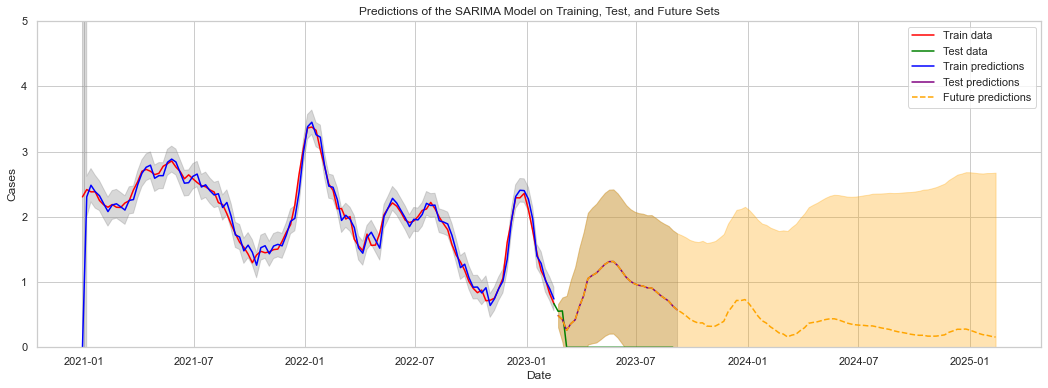

In [40]:
# Obtain predictions for the training set and the test set.
predicciones_train = resultados_sarima.get_prediction()
predicciones_test = resultados_sarima.get_prediction(start=len(train), end=len(train) + len(test) - 1)

# Obtain predicted values and their confidence intervals for both datasets.
predicciones_train_mean = predicciones_train.predicted_mean
intervalo_confianza_train = predicciones_train.conf_int()

predicciones_test_mean = predicciones_test.predicted_mean
intervalo_confianza_test = predicciones_test.conf_int()

# Determine the number of future steps for making the prediction.
pasos_en_el_futuro = 104  

# Perform the prediction into the future
prediccion_futura = resultados_sarima.get_forecast(steps=pasos_en_el_futuro)

# Retrieve the predicted values and their confidence intervals for the future
prediccion_futura_mean = prediccion_futura.predicted_mean
intervalo_confianza_futuro = prediccion_futura.conf_int()

# Generate the dates for the future steps.
ultima_fecha = train.index[-1]
fechas_futuras = pd.date_range(start=ultima_fecha, periods=pasos_en_el_futuro+1, freq='7D')[1:]

# Plot of predictions on the training set and future predictions
plt.figure(figsize=(18, 6))
plt.plot(train.index, train, label='Train data', color='red', linestyle='-')
plt.plot(test.index, test, label='Test data', color='green', linestyle='-')
plt.plot(predicciones_train_mean.index, predicciones_train_mean, label='Train predictions', color='blue', linestyle='-')
plt.plot(predicciones_test_mean.index, predicciones_test_mean, label='Test predictions', color='purple', linestyle='-')
plt.plot(fechas_futuras, prediccion_futura_mean, label='Future predictions', color='orange', linestyle='--')
plt.fill_between(predicciones_train_mean.index, intervalo_confianza_train['lower y'], intervalo_confianza_train['upper y'], color='gray', alpha=0.3)
plt.fill_between(predicciones_test_mean.index, intervalo_confianza_test['lower y'], intervalo_confianza_test['upper y'], color='gray', alpha=0.3)
plt.fill_between(fechas_futuras, intervalo_confianza_futuro['lower y'], intervalo_confianza_futuro['upper y'], color='orange', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Cases')
plt.ylim(0, 5)
plt.title('Predictions of the SARIMA Model on Training, Test, and Future Sets')
plt.legend()

#plt.savefig('SARIMAX.png')

plt.show()

The model preserves the seasonal periodicity of the data, while at the same time, a significant negative trend in the evolution of cases over time is evident.

### 
###
###
###
###
###
### End of part 2
### 
###
###
### 
###
###

# PART 3: SARIMAX Model with Exogenous Variable (People fully immunized per 100 inhabitants)


# 1. Data Selection and Preparation

## 1.1 Data Selection

In [41]:
#Data

new_cases_per_million_ARG = pd.Series(data=df_ARG_vacunas['new_cases_per_million'].values, index=pd.to_datetime(df_ARG_vacunas['date'].values))
inmunizados_cada_100 = pd.Series(data=df_ARG_vacunas['people_fully_vaccinated_per_hundred'].values, index=pd.to_datetime(df_ARG_vacunas['date'].values))

#Eliminate null values
casos = new_cases_per_million_ARG.dropna()

            ##### filter the time series between 2020-12-01 and 2023-09-06 ######

# Define la fecha a partir de la cual deseas mantener los valores.
fecha_limite = pd.to_datetime('2020-12-01')

# Filtra los valores posteriores a la fecha límite.
casos_filtrado = casos[casos.index > fecha_limite]
# Filtra los valores posteriores a la fecha límite.
casos_filtrado = casos_filtrado[casos_filtrado.index < '2023-09-06']

#Lo transformamos a df
time_serie_casos = pd.DataFrame(casos_filtrado)

# Cambiar el nombre de la columna '0' a logcasos
time_serie_casos.rename(columns={0:'log_casos'}, inplace=True)

            ##### filtramos la serie temporal entre 2020-12-01 hasta 2023-09-06 ######

# Define la fecha a partir de la cual deseas mantener los valores.
fecha_limite = pd.to_datetime('2020-12-01')

# Filtra los valores posteriores a la fecha límite.
inmunizados_cada_100 = inmunizados_cada_100[inmunizados_cada_100.index > fecha_limite]
# Filtra los valores posteriores a la fecha límite.
inmunizados_cada_100 = inmunizados_cada_100[inmunizados_cada_100.index < '2023-09-06']

#Lo transformamos a df
time_serie_inmuni = pd.DataFrame(inmunizados_cada_100)

# Cambiar el nombre de la columna '0' a logcasos
time_serie_inmuni.rename(columns={0:'inmunizados_cada_100'}, inplace=True)

# Reemplazar NaN con 0
time_serie_inmuni = time_serie_inmuni.fillna(0)


In [42]:
#### Weekly data
df_semanal_casos = time_serie_casos.resample('7D').mean()
df_semanal_casos = np.log10(df_semanal_casos+ 1)
df_semanal_inmuni= time_serie_inmuni.resample('7D').mean()


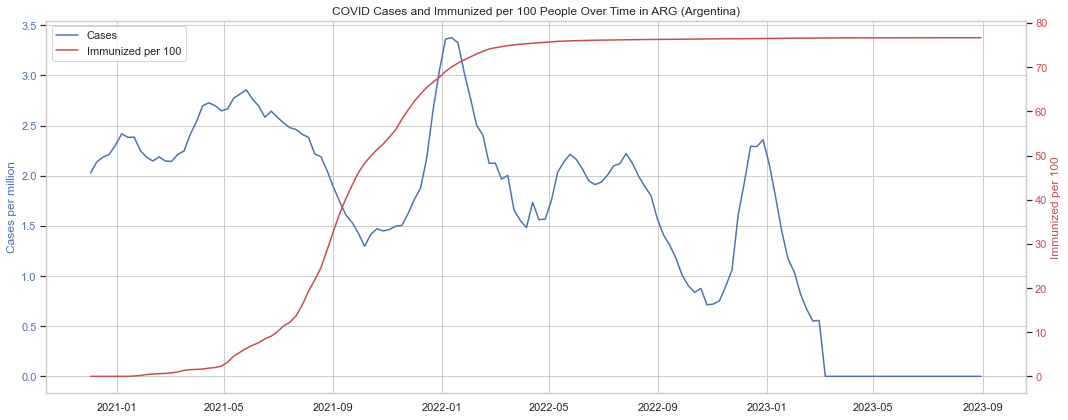

In [44]:
plt.figure(figsize=(15, 6))

ax1 = sns.lineplot(x=df_semanal_casos.index, y="log_casos", data=df_semanal_casos, color='b', label='Cases')
ax1.set_ylabel("Cases per million", color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second Y-axis for the proportion of immunized individuals
ax2 = ax1.twinx()
sns.lineplot(x=df_semanal_inmuni.index, y="inmunizados_cada_100", data=df_semanal_inmuni, color='r', label='Immunized per 100', ax=ax2)
ax2.set_ylabel("Immunized per 100", color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Configure the title and legends
plt.title("COVID Cases and Immunized per 100 People Over Time in ARG (Argentina)")
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
ax1.get_legend().remove()

# Remove the grid background
ax1.grid(True)
ax2.grid(False)

plt.xticks(rotation=45)
# Show the graph
plt.tight_layout()
plt.show()

## 1.2 Data Preparation - DataFrame

In [252]:
# Extract values of 'cases' and 'vaccination' columns into lists
prop_inumni_values = df_semanal_inmuni['inmunizados_cada_100'].tolist()
log_casos_values = df_semanal_casos['log_casos'].tolist() 

start_index = 52
casos_log_lag= log_casos_values[start_index:]

start_index = 0
end_index = 144 - 52
prop_inumni_values_lag = prop_inumni_values[start_index:end_index]


df_semanal_inmuni_con_lag = df_semanal_inmuni.copy()


# Add rop_inmunizados column with 52-week lag
lag_value = 52
df_semanal_inmuni_con_lag['prop_inmunizados_52lagsantes'] = df_semanal_inmuni_con_lag['inmunizados_cada_100'].shift(lag_value)


df_inmuni_lag = df_semanal_inmuni_con_lag.drop('inmunizados_cada_100', axis=1)

# Replace Nan with 0
df_inmuni_lag = df_inmuni_lag.fillna(0)
df_inmuni_lag


            inmunizados_cada_100  prop_inmunizados_52lagsantes
2020-12-02                  0.00                           NaN
2020-12-09                  0.00                           NaN
2020-12-16                  0.00                           NaN
2020-12-23                  0.00                           NaN
2020-12-30                  0.00                           NaN
...                          ...                           ...
2023-08-02                 76.67                     76.220000
2023-08-09                 76.67                     76.237143
2023-08-16                 76.67                     76.247143
2023-08-23                 76.67                     76.262857
2023-08-30                 76.67                     76.277143

[144 rows x 2 columns]


,prop_inmunizados_52lagsantes
2020-12-02,0.000000
2020-12-09,0.000000
2020-12-16,0.000000
2020-12-23,0.000000
2020-12-30,0.000000
...,...
2023-08-02,76.220000
2023-08-09,76.237143
2023-08-16,76.247143
2023-08-23,76.262857


In [253]:
# Copy the DataFrame df_prop_inmunizados to retain the original values
df_semanal_casos_nan = df_semanal_casos.copy()


# Obtain the number of NaN values you wish to add (52 in this case)
num_nans = 52

# Create a series of NaNs
nans = pd.Series([np.nan] * num_nans)

# Append the NaNs to the end of the 'log_cases' column
df_semanal_casos_nan = pd.concat([df_semanal_casos_nan, nans], ignore_index=True, axis=0)

df_semanal_casos_nan = df_semanal_casos_nan.drop(0, axis=1)
# Show the df
print(df_semanal_casos_nan)

# Concatenate the time series without considering the index
combined_series = pd.concat([df_inmuni_lag.reset_index(drop=True), df_semanal_casos_nan.reset_index(drop=True)], axis=1)


# Stablish index date
inicio = '2020-12-01'
fecha_inicial = pd.datetime(2023, 8, 30)
fin = fecha_inicial + timedelta(weeks=52)

frecuencia = '7D'   
rango_fechas = pd.date_range(start=inicio, end=fin, freq=frecuencia)

combined_series.index = rango_fechas
print(combined_series)

     log_casos
0     2.029579
1     2.138371
2     2.185706
3     2.213009
4     2.306181
..         ...
191        NaN
192        NaN
193        NaN
194        NaN
195        NaN

[196 rows x 1 columns]
            prop_inmunizados_52lagsantes  log_casos
2020-12-01                           0.0   2.029579
2020-12-08                           0.0   2.138371
2020-12-15                           0.0   2.185706
2020-12-22                           0.0   2.213009
2020-12-29                           0.0   2.306181
...                                  ...        ...
2024-07-30                           NaN        NaN
2024-08-06                           NaN        NaN
2024-08-13                           NaN        NaN
2024-08-20                           NaN        NaN
2024-08-27                           NaN        NaN

[196 rows x 2 columns]


C:\Users\Julian\AppData\Local\Temp\ipykernel_17116\511878917.py:32: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



# 1.3 Preparation of the exogenous variable for prediction.

In [254]:
                                            ###### Assemble the DataFrame for prediction ############
                                            #################################################
                                            
ultimos_52_valores = df_semanal_inmuni_con_lag.iloc[-52:, 0]
# Create a date range from '2023-09-06' until the arriving date with a frequency of 7D.
nueva_fecha_inicio = "2023-09-06"

nuevas_fechas = pd.date_range(start=nueva_fecha_inicio, freq="7D", periods=52)

ultimos_52_valores.index = nuevas_fechas
# Crea un DataFrame a partir de la Serie ultimos_52_valores
prediccion_df = pd.DataFrame(ultimos_52_valores)
len(prediccion_df)




52

### 1.3.1 Rate of increase in immunizations (last 52 weeks)

In [255]:
# Calculate the rate of increase in the 'vaccination_proportion' column
prediccion_df['tasa_aumento'] = prediccion_df['inmunizados_cada_100'].diff()  

# Calculate the average rate of increase
promedio_tasa_aumento = prediccion_df['tasa_aumento'].mean()

print("Average rate of increase:", promedio_tasa_aumento)

Promedio de la tasa de aumento: 0.007450980392157052


### 1.3.2 Select the immunization rate increase

In [256]:
#Increase in the rate
aumento = 1
promedio_tasa_aumento = promedio_tasa_aumento * aumento

# Initial Value: Last Value of Immunization Proportion
valor = 76.670000
# List to store the results
lista_prop_inmuni_52futuro= []

# Perform the operation 52 times: 1 year onwards
for _ in range(52):
    valor += promedio_tasa_aumento
    lista_prop_inmuni_52futuro.append(valor)


# Append the values to the end of the 'inmunizados_cada_100' column.
prediccion_df = pd.concat([prediccion_df['inmunizados_cada_100'], pd.Series(lista_prop_inmuni_52futuro)], axis=0)
df1=pd.DataFrame(prediccion_df)

#### We add the index with the corresponding dates
inicio = '2023-09-06'

# Initial date
fecha_inicial = pd.datetime(2023, 9, 6)

from datetime import timedelta
# Add 52 weeks (364 days)
fin = fecha_inicial + timedelta(weeks=103)
frecuencia = '7D' 
rango_fechas = pd.date_range(start=inicio, end=fin, freq=frecuencia)

# Set the date range as the new index of the DataFrame
df1.index = rango_fechas
prediccion_df = pd.DataFrame(df1)
prediccion_df.rename(columns={'0': 'inmunizados_cada_100'}, inplace=True)

#Add a column 'logcases_future'.
prediccion_df['logcasos_futuros'] =np.nan

[76.67745098039215, 76.6849019607843, 76.69235294117645, 76.6998039215686, 76.70725490196075, 76.7147058823529, 76.72215686274505, 76.7296078431372, 76.73705882352935, 76.7445098039215, 76.75196078431365, 76.7594117647058, 76.76686274509795, 76.7743137254901, 76.78176470588225, 76.7892156862744, 76.79666666666655, 76.8041176470587, 76.81156862745085, 76.819019607843, 76.82647058823515, 76.8339215686273, 76.84137254901945, 76.8488235294116, 76.85627450980375, 76.8637254901959, 76.87117647058805, 76.8786274509802, 76.88607843137235, 76.8935294117645, 76.90098039215665, 76.9084313725488, 76.91588235294095, 76.9233333333331, 76.93078431372525, 76.9382352941174, 76.94568627450955, 76.9531372549017, 76.96058823529386, 76.968039215686, 76.97549019607816, 76.9829411764703, 76.99039215686246, 76.9978431372546, 77.00529411764676, 77.0127450980389, 77.02019607843106, 77.0276470588232, 77.03509803921536, 77.0425490196075, 77.04999999999966, 77.0574509803918]


C:\Users\Julian\AppData\Local\Temp\ipykernel_17116\961056770.py:28: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [257]:
prediccion_df.tail()

,0,logcasos_futuros
2025-07-30,77.027647,NaN
2025-08-06,77.035098,NaN
2025-08-13,77.042549,NaN
2025-08-20,77.050000,NaN
2025-08-27,77.057451,NaN


# 2. SARIMAX Model with Exogenous Variable


In [258]:
train = combined_series[:'2023-02-15']
test = combined_series['2023-02-15':'2023-08-30'] 

## 2.1 Search for the Best Hyperparameters

In [ ]:
# Specify the ranges of values for the hyperparameters you wish to test.
p_values = [2,4]
d_values = [1,2]
q_values = [17, 18, 6,4]
P_values = [1,2]
D_values = [0, 1]
Q_values = [0]
s_values = [52]  


best_mse = float('inf')
best_params = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        for s in s_values:
                            try:
                                modelo_sarima =  SARIMAX(train['log_casos'], exog=train['prop_inmunizados_52lagsantes'], order=(p, d, q), seasonal_order=(P, D, Q, s))
                                resultados_sarima = modelo_sarima.fit()
                                predicciones = resultados_sarima.get_forecast(steps=len(train),exog=train['prop_inmunizados_52lagsantes'])
                                mse = mean_squared_error(train['log_casos'], predicciones.predicted_mean)
                                
                                if mse < best_mse:
                                    best_mse = mse
                                    best_params = (p, d, q, P, D, Q, s)
                                    
                                print(f'Orden: ({p},{d},{q}) - Estacional: ({P},{D},{Q},{s}) - MSE: {mse}')
                            except Exception as e:
                                print(f'Error en ({p},{d},{q}), ({P},{D},{Q},{s}): {e}')
                                continue

print(f"Best Hyperparameter Combination: {best_params}")
print(f"Lowers MSE: {best_mse}")

Best Hyperparameter Combination: (2, 1, 18, 1, 0, 0, 52)

Lowest MSE: 0.26855653291206244

## 2.2 Training of the SARIMAX Model

In [259]:
#Model
modelo_sarima_exog = SARIMAX(train['log_casos'], exog=train['prop_inmunizados_52lagsantes'], order=(2, 1, 18), seasonal_order=(1, 0, 0, 52))
resultados_sarima = modelo_sarima_exog.fit()
print('Resumen modelo SARIMA\n', resultados_sarima.summary())

c:\Users\Julian\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



c:\Users\Julian\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Resumen modelo SARIMA
                                       SARIMAX Results                                       
Dep. Variable:                            log_casos   No. Observations:                  116
Model:             SARIMAX(2, 1, 18)x(1, 0, [], 52)   Log Likelihood                 105.851
Date:                              Mon, 25 Sep 2023   AIC                           -165.702
Time:                                      18:47:51   BIC                           -102.568
Sample:                                  12-01-2020   HQIC                          -140.076
                                       - 02-14-2023                                         
Covariance Type:                                opg                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
prop_inmunizados_52lagsantes    -0.0140

## 2.3 Model Prediction and Evaluation

In [260]:
futuro = prediccion_df[0] 
predicciones_futuro = resultados_sarima.get_prediction(start=len(train), end=len(train) + len(futuro) - 1,exog=prediccion_df[0])
futuro_mean = predicciones_futuro.predicted_mean
intervalo_confianza_futuro= predicciones_futuro.conf_int()

futuro_mean

2023-02-21    0.437852
2023-02-28    0.360048
2023-03-07    0.211019
2023-03-14    0.308491
2023-03-21    0.371464
                ...   
2025-01-14    0.974816
2025-01-21    0.953701
2025-01-28    0.943959
2025-02-04    0.927228
2025-02-11    0.915522
Freq: 7D, Name: predicted_mean, Length: 104, dtype: float64

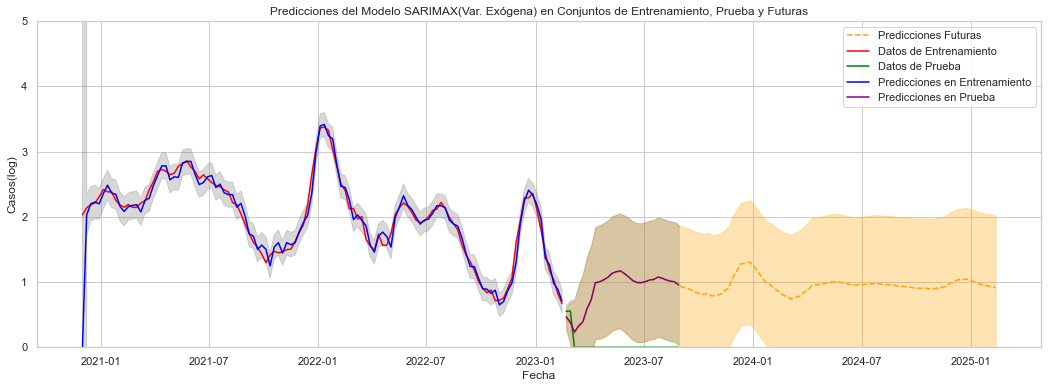

In [261]:
# Obtén las predicciones para el conjunto de entrenamiento y el conjunto de prueba
predicciones_train = resultados_sarima.get_prediction(exog=train['prop_inmunizados_52lagsantes'])
predicciones_test = resultados_sarima.get_prediction(start=len(train), end=len(train) + len(test) - 1, exog=test['prop_inmunizados_52lagsantes'])
predicciones_futuro = resultados_sarima.get_prediction(start=len(train), end=len(train) + len(futuro) - 1,exog=prediccion_df[0])
# Obtén los valores predichos y sus intervalos de confianza para ambos conjuntos
predicciones_train_mean = predicciones_train.predicted_mean
intervalo_confianza_train = predicciones_train.conf_int()

predicciones_test_mean = predicciones_test.predicted_mean
intervalo_confianza_test = predicciones_test.conf_int()

futuro_mean = predicciones_futuro.predicted_mean
intervalo_confianza_futuro= predicciones_futuro.conf_int()

# Gráfica de las predicciones en el conjunto de entrenamiento y prueba
plt.figure(figsize=(18, 6))
##
plt.plot(futuro_mean.index, futuro_mean, label='Future predictions',color='orange', linestyle='--')
plt.plot(train.index, train['log_casos'], label='Train data', color='red', linestyle='-')
plt.plot(test.index, test['log_casos'], label='Test data', color='green', linestyle='-')
plt.plot(predicciones_train_mean.index, predicciones_train_mean, label='Train predictions', color='blue', linestyle='-')
plt.plot(predicciones_test_mean.index, predicciones_test_mean, label='Test predictions', color='purple', linestyle='-')
plt.fill_between(futuro_mean.index, intervalo_confianza_futuro['lower log_casos'], intervalo_confianza_futuro['upper log_casos'], color='orange', alpha=0.3)
plt.fill_between(predicciones_train_mean.index, intervalo_confianza_train['lower log_casos'], intervalo_confianza_train['upper log_casos'], color='gray', alpha=0.3)
plt.fill_between(predicciones_test_mean.index, intervalo_confianza_test['lower log_casos'], intervalo_confianza_test['upper log_casos'], color='gray', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Cases')
plt.ylim(0, 5)
plt.title('Predictions of the SARIMAX(Exogenous Variable) Model on Train, Test and Future Sets')
plt.legend()
plt.grid(True) 


plt.show()


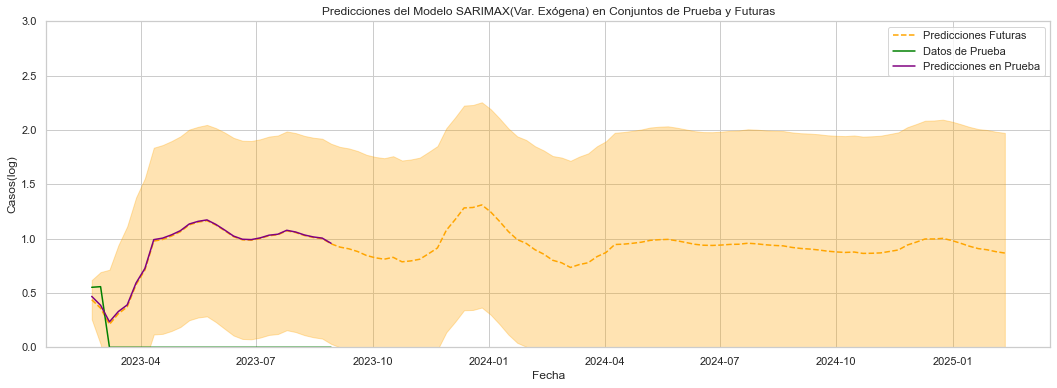

In [140]:
# Retrieve the predictions for the training set and the test set
predicciones_train = resultados_sarima.get_prediction(exog=train['prop_inmunizados_52lagsantes'])
predicciones_test = resultados_sarima.get_prediction(start=len(train), end=len(train) + len(test) - 1, exog=test['prop_inmunizados_52lagsantes'])
predicciones_futuro = resultados_sarima.get_prediction(start=len(train), end=len(train) + len(futuro) - 1,exog=prediccion_df[0])
# Obtain the predicted values and their confidence intervals for both sets
predicciones_train_mean = predicciones_train.predicted_mean
intervalo_confianza_train = predicciones_train.conf_int()

predicciones_test_mean = predicciones_test.predicted_mean
intervalo_confianza_test = predicciones_test.conf_int()

futuro_mean = predicciones_futuro.predicted_mean
intervalo_confianza_futuro= predicciones_futuro.conf_int()

# Plot of predictions on the training and test sets
plt.figure(figsize=(18, 6))
plt.plot(futuro_mean.index, futuro_mean, label='Future predicitons',color='orange', linestyle='--')
plt.plot(test.index, test['log_casos'], label='Test', color='green', linestyle='-')
plt.plot(predicciones_test_mean.index, predicciones_test_mean, label='Test predictions', color='purple', linestyle='-')
plt.fill_between(futuro_mean.index, intervalo_confianza_futuro['lower log_casos'], intervalo_confianza_futuro['upper log_casos'], color='orange', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Cases')
plt.ylim(0, 3)
plt.title('Predictions of the SARIMAX(Exogenous Variable) Model on Test and Future Sets')
plt.legend()
plt.grid(True) 

#plt.savefig('SARIMAX_VE10.png')

plt.show()